# Common statistical tests are linear models (or: how to teach stats)

[Source](https://lindeloev.github.io/tests-as-linear/)

This document is summarised in the table below. It shows the linear models underlying common parametric and “non-parametric” tests. Formulating all the tests in the same language highlights the many similarities between them. 

![title](images/r_linear_tests_cheat_sheet.png)

## 1 The simplicity underlying common tests

Most of the common statistical models (t-test, correlation, ANOVA; chi-square, etc.) are special cases of linear models or a very close approximation. This beautiful simplicity means that there is less to learn. In particular, it all comes down to $ y=a⋅x+b $ which most students know from high school. Unfortunately, stats intro courses are usually taught as if each test is an independent tool, needlessly making life more complicated for students and teachers alike.

This needless complexity multiplies when students try to rote learn the parametric assumptions underlying each test separately rather than deducing them from the linear model.

For this reason, I think that teaching linear models first and foremost and then name-dropping the special cases along the way makes for an excellent teaching strategy, emphasizing understanding over rote learning. Since linear models are the same across frequentist, Bayesian, and permutation-based inferences, I’d argue that it’s better to start with modeling than p-values, type-1 errors, Bayes factors, or other inferences.

Use the menu to jump to your favourite section. There are links to lots of similar (though more scattered) stuff under sources and teaching materials. I hope that you will join in suggesting improvements or submitting improvements yourself in the Github repo to this page. Let’s make it awesome!

## 2 Settings and Toy Data

In [1]:
# Load packages for data handling and plotting
library(tidyverse)
library(patchwork)
library(broom)

# Reproducible "random" results
set.seed(40)

# Generate normal data with known parameters
rnorm_fixed = function(N, mu = 0, sd = 1) {
  scale(rnorm(N)) * sd + mu
}

# Plot style.
theme_axis = function(P,
                      jitter = FALSE,
                      xlim = c(-0.5, 2),
                      ylim = c(-0.5, 2),
                      legend.position = NULL) {
  P = P + theme_bw(15) +
    geom_segment(
      x = -1000, xend = 1000,
      y = 0, yend = 0,
      lty = 2, color = 'dark gray', lwd = 0.5
    ) +
    geom_segment(
      x = 0, xend = 0,
      y = -1000, yend = 1000,
      lty = 2, color = 'dark gray', lwd = 0.5
    ) +
    coord_cartesian(xlim = xlim, ylim = ylim) +
    theme(
      axis.title = element_blank(),
      axis.text = element_blank(),
      axis.ticks = element_blank(),
      panel.border = element_blank(),
      panel.grid = element_blank(),
      legend.position = legend.position
    )
  
  # Return jittered or non-jittered plot?
  if (jitter) {
    P + geom_jitter(width = 0.1, size = 2)
  }
  else {
    P + geom_point(size = 2)
  }
}

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘patchwork’ was built under R version 3.6.3”

For a start, we’ll keep it simple and play with three standard normals in wide (`a`, `b`, `c`) and long format (`value`, `group`):

In [2]:
# Wide format (sort of)
#y = rnorm_fixed(50, mu=0.3, sd=2)  # Almost zero mean.
y = c(rnorm(15), exp(rnorm(15)), runif(20, min = -3, max = 0))  # Almost zero mean, not normal
x = rnorm_fixed(50, mu = 0, sd = 1)  # Used in correlation where this is on x-axis
y2 = rnorm_fixed(50, mu = 0.5, sd = 1.5)  # Used in two means

# Long format data with indicator
value = c(y, y2)
group = rep(c('y1', 'y2'), each = 50)

## 3 Pearson and Spearman Correlation

#### 3.0.1 Theory: As linear models ####

Model: the recipe for $y$ is a slope ($\beta_1$) times $x$ plus an intercept ($\beta_0$, aka a straight line).

$$ y = \beta_0 + \beta_1x $$  $$ H_0 : \beta_1 = 0 $$

This is a mathy way of writing the good old $y = mx + b$ (but here reordered as $y = b + mx$). In R we are lazy and write `y ~ 1 + x` which R reads like `y = 1 * number + x * othernumber` and the task of t-tests, lm, etc is simply to find numbers that best predict $y$.

However you write it, it's an intercept ($\beta_0$) and a slope ($\beta_1$) yielding a straight line.

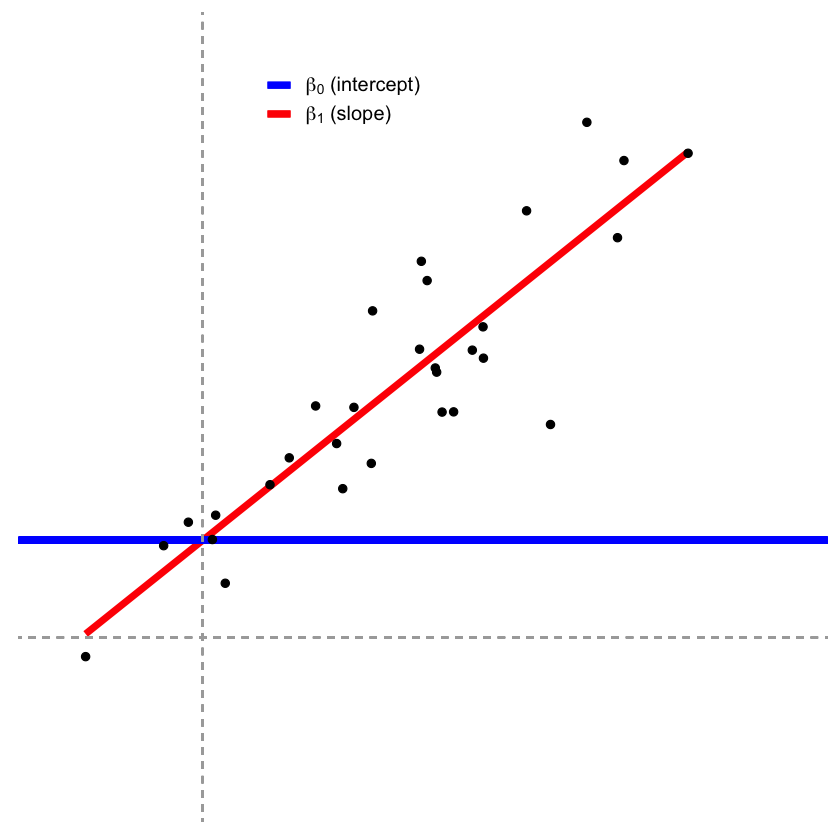

In [3]:
# Created fixed correlation data
D_correlation = data.frame(MASS::mvrnorm(30, mu = c(0.9, 0.9), Sigma = matrix(c(1, 0.8, 1, 0.8), ncol = 2), empirical = TRUE))

# Add labels (for next plot)
D_correlation$label_num = sprintf('(%.1f,%.1f)', D_correlation$X1, D_correlation$X2)
D_correlation$label_rank = sprintf('(%i,%i)', rank(D_correlation$X1), rank(D_correlation$X2))

# Plot it
fit = lm(I(X2 * 0.5 + 0.4) ~ I(X1 * 0.5 + 0.2), D_correlation)
intercept_pearson = coefficients(fit)[1]

P_pearson = ggplot(D_correlation, aes(x=X1*0.5+0.2, y=X2*0.5+0.4)) +
  geom_smooth(method=lm, se=FALSE, lwd=2, aes(colour='beta_1')) + 
  geom_segment(x=-100, xend=100, 
               y=intercept_pearson, yend=intercept_pearson, 
               lwd=2, aes(color="beta_0")) + 
  scale_color_manual(name=NULL, values=c("blue", "red"), labels=c(bquote(beta[0]*" (intercept)"), bquote(beta[1]*" (slope)")))
  
theme_axis(P_pearson, legend.position = c(0.4, 0.9))

This is often simply called a **regression** model which can be extended to multiple regression where there are several $\beta$s and on the right-hand side multiplied with the predictors. **Everything below, from one-sample t-test to two-way ANOVA are just special cases of this system. Nothing more, nothing less.**

As the name implies, the Spearman rank correlation is a Pearson correlation on rank-transformed $x$ and $y$:

$$ rank(y) = \beta_0 + \beta_1 \cdot rank(x) $$ $$ H_0 : \beta_1 = 0 $$

I’ll introduce ranks in a minute. For now, notice that the correlation coefficient of the linear model is identical to a “real” Pearson correlation, but p-values are an approximation which is is appropriate for samples greater than N=10 and almost perfect when N > 20.

Such a nice and non-mysterious equivalence that many students are left unaware of! Visualizing them side by side including data labels, we see this rank-transformation in action:

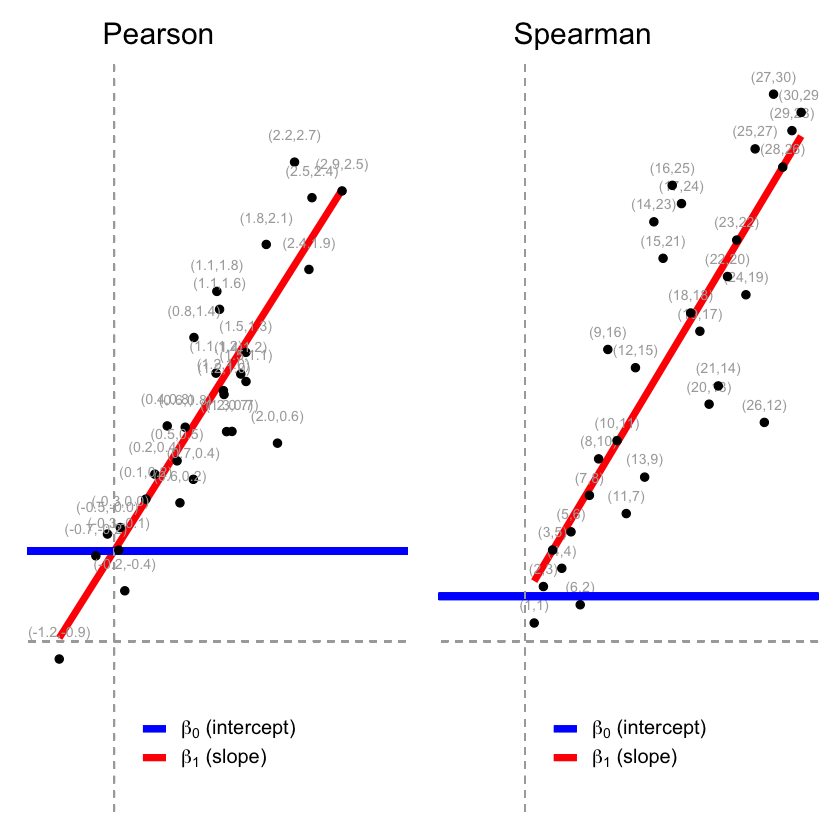

In [4]:
# Spearman intercept
intercept_spearman = coefficients(lm(rank(X2) ~ rank(X1), D_correlation))[1]

# Spearman plot
P_spearman = ggplot(D_correlation, aes(x=rank(X1), y=rank(X2))) +
  geom_smooth(method=lm, se=FALSE, lwd=2, aes(color='beta_1')) + 
  geom_text(aes(label=label_rank), nudge_y=1, size=3, color='dark gray') + 
  geom_segment(x=-100, xend=100, 
               y=intercept_spearman, yend=intercept_spearman, 
               lwd=2, aes(color='beta_0')) + 
  scale_color_manual(name=NULL, values=c("blue", "red"), labels=c(bquote(beta[0]*" (intercept)"), bquote(beta[1]*" (slope)")))

# Stich together using patchwork
(theme_axis(P_pearson, legend.position=c(0.5, 0.1)) + geom_text(aes(label=label_num), nudge_y=0.1, size=3, color='dark gray') + labs(title='         Pearson')) + (theme_axis(P_spearman, xlim=c(-7.5, 30), ylim=c(-7.5, 30), legend.position=c(0.5, 0.1)) + labs(title='         Spearman'))

#### 3.0.2 Theory: Rank-transformation ####

`rank` simply takes a list of numbers and “replaces” them with the integers of their rank (1st smallest, 2nd smallest, 3rd smallest, etc.). So the result of the rank-transformation `rank(c(3.6, 3.4, -5.0, 8.2))` is `3, 2, 1, 4`. See that in the figure above?

A *signed* rank is the same, just where we rank according to absolute size first and then add in the sign second. So the signed rank here would be 2, 1, -3, 4. Or in code:

In [5]:
signed_rank = function(x) sign(x) * rank(abs(x))

I hope I don’t offend anyone when I say that ranks are easy; yet it’s all you need to do to convert most parametric tests into their “non-parametric” counterparts! *One interesting implication is that many “non-parametric tests” are about as parametric as their parametric counterparts with means, standard deviations, homogeneity of variance, etc. - just on rank-transformed data. That’s why I put “non-parametric” in quotation marks.*

#### 3.0.3 R code: Pearson correlation ####

It couldn’t be much simpler to run these models in R. They yield identical `p` and `t`, but there’s a catch: `lm` gives you the *slope* and even though that is usually much more interpretable and informative than the correlation coefficient `r`, you may still want `r`. Luckily, the **slope becomes `r`** if `x` and `y` have identical standard deviations. For now, we will use `scale(x)` to make $SD(x)=1.0$ and $SD(y)=1.0$. The CIs are not exactly identical, but very close.

In [6]:
a = cor.test(y, x, method = "pearson") # Built-in
b = lm(y ~ 1 + x) # Equivalent linear model: y = Beta0*1 + Beta1*x
c = lm(scale(y) ~ 1 + scale(x))  # On scaled vars to recover r

In [7]:
a


	Pearson's product-moment correlation

data:  y and x
t = -0.33651, df = 48, p-value = 0.738
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3225066  0.2329799
sample estimates:
        cor 
-0.04851394 


In [8]:
summary(b)


Call:
lm(formula = y ~ 1 + x)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6265 -1.1753 -0.3718  0.6607  5.7109 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.09522    0.25647  -0.371    0.712
x           -0.08718    0.25907  -0.337    0.738

Residual standard error: 1.814 on 48 degrees of freedom
Multiple R-squared:  0.002354,	Adjusted R-squared:  -0.01843 
F-statistic: 0.1132 on 1 and 48 DF,  p-value: 0.738


In [9]:
stats::confint(b, level = 0.95)

,2.5 %,97.5 %
(Intercept),-0.6108818,0.4204500
x,-0.6080820,0.4337204


In [10]:
summary(c)


Call:
lm(formula = scale(y) ~ 1 + scale(x))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.4616 -0.6541 -0.2069  0.3677  3.1780 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) -2.206e-17  1.427e-01   0.000    1.000
scale(x)    -4.851e-02  1.442e-01  -0.337    0.738

Residual standard error: 1.009 on 48 degrees of freedom
Multiple R-squared:  0.002354,	Adjusted R-squared:  -0.01843 
F-statistic: 0.1132 on 1 and 48 DF,  p-value: 0.738


In [11]:
stats::confint(c, level = 0.95)

,2.5 %,97.5 %
(Intercept),-0.2869551,0.2869551
scale(x),-0.3383823,0.2413545


### 3.0.4 R code: Spearman correlation ###

Note that we can interpret the slope which is the number of ranks $y$ change for each rank on $x$. I think that this is a pretty interesting number. However, the intercept is less interpretable since it lies at $rank(x)=0$ which is impossible since x starts at 1.

See the identical `r` (now “rho”) and `p`:

In [12]:
# Spearman correlation
a = cor.test(y, x, method = "spearman") # Built-in
b = lm(rank(y) ~ 1 + rank(x)) # Equivalent linear model

In [13]:
a


	Spearman's rank correlation rho

data:  y and x
S = 21956, p-value = 0.7072
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.05430972 


In [14]:
summary(b)


Call:
lm(formula = rank(y) ~ 1 + rank(x))

Residuals:
     Min       1Q   Median       3Q      Max 
-23.8211 -12.0056  -0.0272  12.5215  25.6677 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 26.88490    4.22287   6.366 6.89e-08 ***
rank(x)     -0.05431    0.14412  -0.377    0.708    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.71 on 48 degrees of freedom
Multiple R-squared:  0.00295,	Adjusted R-squared:  -0.01782 
F-statistic: 0.142 on 1 and 48 DF,  p-value: 0.708


## 4 One Mean
### 4.1 One Sample t-test and Wilcoxon signed-rank
#### 4.1.1 Theory: As Linear Models
**t-test model**: A single number predicts $y$.
$$ y = \beta_0$$ $$ H_0 : \beta_0 = 0 $$
In other words, it’s our good old $ y=\beta_0+\beta_1∗x $ where the last term is gone since there is no $x$ (essentially $ x=0 $, see left figure below).

The same is approximately true for Wilcoxon signed-rank test, just with the signed ranks of $y$ instead of $y$ itself (see right panel below).

signed_rank(y)=β0

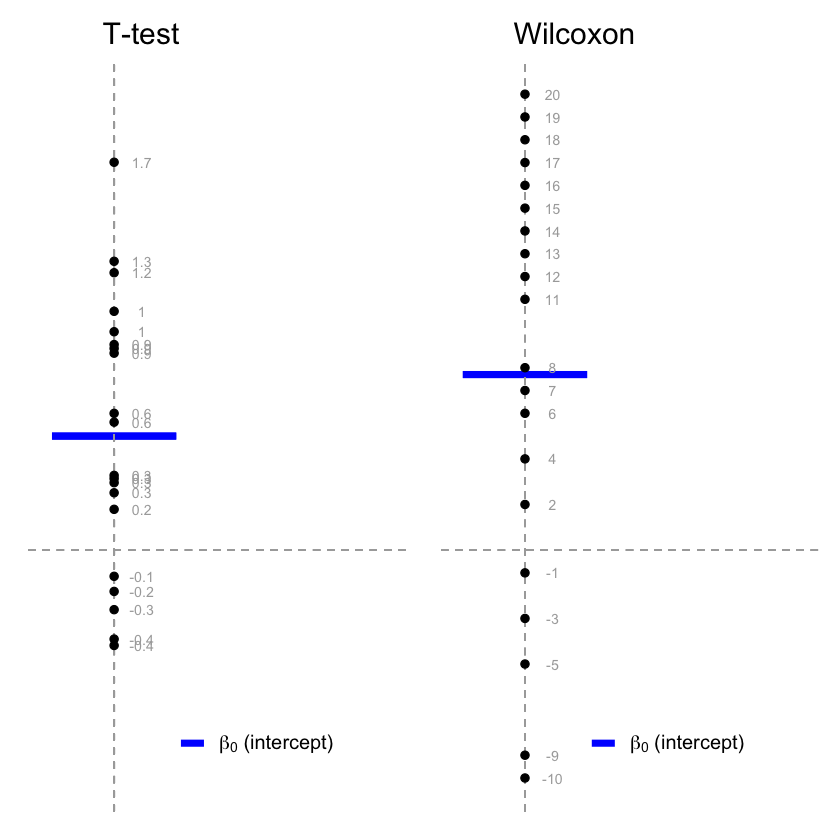

In [15]:
# T-test
D_t1 = data.frame(y = rnorm_fixed(20, 0.5, 0.6),
                  x = runif(20, 0.93, 1.07))  # Fix mean and SD

P_t1 = ggplot(D_t1, aes(y = y, x = 0)) + 
  stat_summary(fun.y=mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y.., color='beta_0'), lwd=2) +
  scale_color_manual(name = NULL, values = c("blue"), labels = c(bquote(beta[0] * " (intercept)"))) +
  
  geom_text(aes(label = round(y, 1)), nudge_x = 0.2, size = 3, color = 'dark gray') + 
  labs(title='         T-test')

# Wilcoxon
D_t1_rank = data.frame(y = signed_rank(D_t1$y))

P_t1_rank = ggplot(D_t1_rank, aes(y = y, x = 0)) + 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..,  color = 'beta_0'), lwd = 2) +
  scale_color_manual(name = NULL, values = c("blue"), labels = c(bquote(beta[0] * " (intercept)"))) +

  geom_text(aes(label = y), nudge_x = 0.2, size = 3, color = 'dark gray') + 
  labs(title='         Wilcoxon')


# Stich together using patchwork
theme_axis(P_t1, ylim = c(-1, 2), legend.position = c(0.6, 0.1)) + 
  theme_axis(P_t1_rank, ylim = NULL,  legend.position = c(0.6, 0.1))

#### 4.1.2 R code: One-sample t-test

Try running the R code below and see that the linear model (lm) produces the same $t$, $p$, and $r$ as the built-in t.test. The confidence interval is not presented in the output of lm but is also identical if you use `stats::confint(lm(...))`:

In [16]:
# Built-in t-test
a = t.test(y)

# Equivalent linear model: intercept-only
b = lm(y ~ 1)

In [17]:
a


	One Sample t-test

data:  y
t = -0.37466, df = 49, p-value = 0.7095
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.6059252  0.4154934
sample estimates:
  mean of x 
-0.09521589 


In [18]:
summary(b)


Call:
lm(formula = y ~ 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6877 -1.1888 -0.3123  0.5868  5.5883 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.09522    0.25414  -0.375     0.71

Residual standard error: 1.797 on 49 degrees of freedom


In [19]:
stats::confint(b)

,2.5 %,97.5 %
(Intercept),-0.6059252,0.4154934


#### 4.1.3 R code: Wilcoxon signed-rank test

In addition to matching p-values, `lm` also gives us the mean signed rank, which I find to be an informative number.

In [20]:
# Built-in
a = wilcox.test(y)

# Equivalent linear model
b = lm(signed_rank(y) ~ 1)  # See? Same model as above, just on signed ranks

# Bonus: of course also works for one-sample t-test
c = t.test(signed_rank(y))

In [21]:
a


	Wilcoxon signed rank test with continuity correction

data:  y
V = 508, p-value = 0.213
alternative hypothesis: true location is not equal to 0


In [22]:
summary(b)


Call:
lm(formula = signed_rank(y) ~ 1)

Residuals:
   Min     1Q Median     3Q    Max 
-41.82 -22.57  -5.32  18.68  55.18 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    -5.18       4.12  -1.257    0.215

Residual standard error: 29.13 on 49 degrees of freedom


In [23]:
c


	One Sample t-test

data:  signed_rank(y)
t = -1.2573, df = 49, p-value = 0.2146
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -13.459062   3.099062
sample estimates:
mean of x 
    -5.18 


### 4.2 Paired samples t-test and Wilcoxon matched pairs
#### 4.2.1 Theory: As linear models

**t-test model:** a single number (intercept) predicts the pairwise differences.
$$ y_2 - y_1 = \beta_0 $$  $$ H_0 : \beta_0 = 0 $$
This means that there is just one $y=y2−y1$ to predict and it becomes a one-sample t-test on the pairwise differences. The visualization is therefore also the same as for the one-sample t-test. At the risk of overcomplicating a simple substraction, you can think of these pairwise differences as slopes (see left panel of the figure), which we can represent as y-offsets (see right panel of the figure):

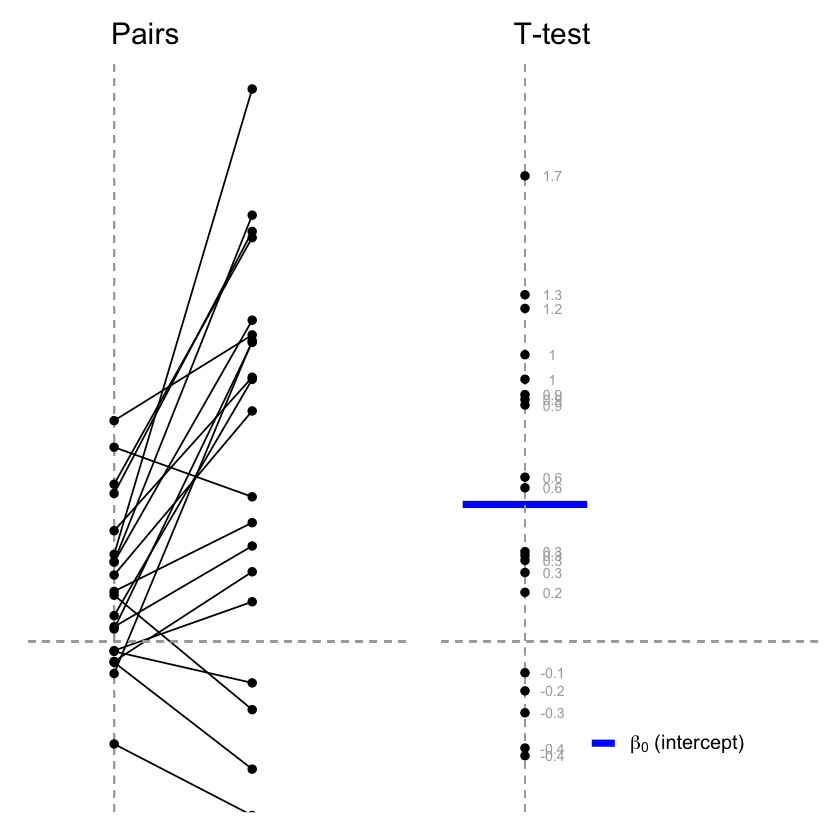

In [24]:
# Data for plot
N = nrow(D_t1)
start = rnorm_fixed(N, 0.2, 0.3)
D_tpaired = data.frame(
  x = rep(c(0, 1), each = N),
  y = c(start, start + D_t1$y),
  id = 1:N
)

# Plot
P_tpaired = ggplot(D_tpaired, aes(x = x, y = y)) +
  geom_line(aes(group = id)) +
  labs(title = '          Pairs')

# Use patchwork to put them side-by-side
theme_axis(P_tpaired) + theme_axis(P_t1, legend.position = c(0.6, 0.1))

Similarly, the **Wilcoxon matched pairs** only differ from **Wilcoxon signed-rank** in that it’s testing the signed ranks of the pairwise $y−x$ differences.

$$signed\_rank(y_2−y_1)=\beta_0$$ $$H_0:\beta_0=0$$

#### 4.2.2 R Code: Paired Sample t-test

In [25]:
a = t.test(y, y2, paired = TRUE) # Built-in paired t-test
b = lm(y - y2 ~ 1) # Equivalent linear model

In [26]:
a


	Paired t-test

data:  y and y2
t = -1.7108, df = 49, p-value = 0.09345
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.2943926  0.1039608
sample estimates:
mean of the differences 
             -0.5952159 


In [27]:
summary(b)


Call:
lm(formula = y - y2 ~ 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9699 -1.4071 -0.0062  1.0771  7.2116 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.5952     0.3479  -1.711   0.0934 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.46 on 49 degrees of freedom


In [28]:
stats::confint(b)

,2.5 %,97.5 %
(Intercept),-1.294393,0.1039608


In [29]:
# Built-in Wilcoxon matched pairs
a = wilcox.test(y, y2, paired = TRUE)

# Equivalent linear model:
b = lm(signed_rank(y - y2) ~ 1)

# Bonus: identical to one-sample t-test ong signed ranks
c = t.test(signed_rank(y - y2))

In [30]:
a


	Wilcoxon signed rank test with continuity correction

data:  y and y2
V = 429, p-value = 0.04466
alternative hypothesis: true location shift is not equal to 0


In [31]:
summary(b)


Call:
lm(formula = signed_rank(y - y2) ~ 1)

Residuals:
   Min     1Q Median     3Q    Max 
-40.66 -23.16  -4.66  20.84  58.34 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   -8.340      4.013  -2.078   0.0429 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.37 on 49 degrees of freedom


In [32]:
c


	One Sample t-test

data:  signed_rank(y - y2)
t = -2.0785, df = 49, p-value = 0.04293
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -16.4036084  -0.2763916
sample estimates:
mean of x 
    -8.34 


## 5 Two means
### 5.1 Independent t-test and Mann-Whitney U
#### 5.1.1 Theory: As linear models

**Independent t-test model**: two means predict $y$

$$ y_i = \beta_0 + \beta_1x_i $$ $$ H_0 : \beta_1 = 0 $$

where $x_i$ is an indicator (0 or 1) saying whether data point $i$ was sampled from one or the other group. Indicator variables (also called “[dummy coding](https://en.wikipedia.org/wiki/Dummy_variable_(statistics))" underly a lot of linear models and we’ll take an aside to see how it works in a minute.

**Mann-Whitney U** (also known as **Wilcoxon rank-sum test** for two independent groups; no signed rank this time) is the same model to a very close approximation, just on the *ranks* of $x$ and $y$ instead of the actual values:

$$ rank(y_i)=\beta_0+\beta_1x_i$$ $$H_0:\beta_1=0$$

To me, equivalences like this make “non-parametric” statistics much easier to understand. The approximation is appropriate when the sample size is larger than 11 in each group and virtually perfect when N > 30 in each group.

#### 5.1.2 Theory: Dummy coding

Dummy coding can be understood visually. The indicator is on the x-axis so data points from the first group are located at $x=0$ and data points from the second group is located at $x=1$. Then $\beta_0$ is the intercept (blue line) and $\beta_1$ is the slope between the two means (red line). Why? Because when $\Delta_x=1$ the slope equals the difference because:

$$ slope=\Delta_y/\Delta_x=\Delta_y/1=\Delta_y=difference $$

Magic! Even categorical differences can be modelled using linear models! It’s a true Swiss army knife.

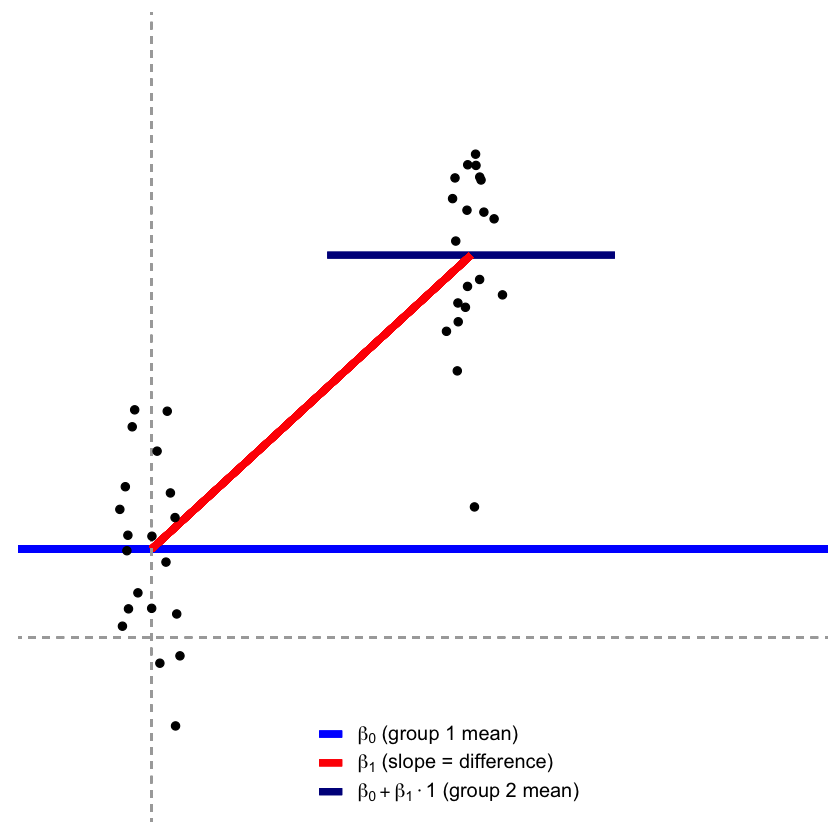

In [33]:
# Data
N = 20  # Number of data points per group
D_t2 = data.frame(
  x = rep(c(0, 1), each=N),
  y = c(rnorm_fixed(N, 0.3, 0.3), rnorm_fixed(N, 1.3, 0.3))
)

# Plot
P_t2 = ggplot(D_t2, aes(x=x, y=y)) + 
  stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..,  color = 'something'), lwd = 2) +
  geom_segment(x = -10, xend = 10, y = 0.3, yend = 0.3, lwd = 2, aes(color = 'beta_0')) + 
  geom_segment(x = 0, xend = 1, y = 0.3, yend = 1.3, lwd = 2, aes(color = 'beta_1')) + 
  
  scale_color_manual(name = NULL, values = c("blue", "red", "darkblue"), labels=c(bquote(beta[0]*" (group 1 mean)"), bquote(beta[1]*" (slope = difference)"), bquote(beta[0]+beta[1]%.%1*" (group 2 mean)")))
  #scale_x_discrete(breaks=c(0.5, 1.5), labels=c('1', '2'))

theme_axis(P_t2, jitter = TRUE, xlim = c(-0.3, 2), legend.position = c(0.53, 0.08))

#### 5.1.3 Theory: Dummy coding (continued)

If you feel like you get dummy coding now, just skip ahead to the next section. Here is a more elaborate explanation of dummy coding:

If a data point was sampled from the first group, i.e., when $x_i=0$, the model simply becomes $y=\beta_0+\beta_1\cdot0=\beta_0$ . In other words, the model predicts that that data point is $\beta_0$. It turns out that the $\beta$ which best predicts a set of data points is the mean of those data points, so $\beta_0$ is the mean of group 1.

On the other hand, data points sampled from the second group would have $x_i=1$ so the model becomes $y_i=\beta_0+\beta_1⋅1 = \beta_0+\beta_1$. In other words, we add $\beta_1$ to “shift” from the mean of the first group to the mean of the second group. Thus $\beta_1$ becomes the mean difference between the groups.

As an example, say group 1 is 25 years old ($\beta_0=25$) and group 2 is 28 years old ($\beta_1=3$), then the model for a person in group 1 is $y=25+3⋅0=25$ and the model for a person in group 2 is $y=25+3⋅1=28$.

Hooray, it works! For first-timers it takes a few moments to understand dummy coding, but you only need to know addition and multiplication to get there!

#### R code: Independent t-test

As a reminder, when we write `y ~ 1 + x` in R, it is shorthand for $y=\beta_0⋅1+\beta_1⋅x$ and R goes on computing the $\beta$s for you. Thus `y ~ 1 + x` is the R-way of writing $y=a⋅x+b$.

Notice the identical `t`, `df`, `p`, and estimates. We can get the confidence interval by running `stats::confint(lm(...))`.

In [34]:
# Built-in independent t-test on wide data
a = t.test(y, y2, var.equal = TRUE)

# Be explicit about the underlying linear model by hand-dummy-coding:
group_y2 = ifelse(group == 'y2', 1, 0)  # 1 if group == y2, 0 otherwise
b = lm(value ~ 1 + group_y2)  # Using our hand-made dummy regressor

# Note: We could also do the dummy-coding in the model
# specification itself. Same result.
c = lm(value ~ 1 + I(group == 'y2'))

In [35]:
a


	Two Sample t-test

data:  y and y2
t = -1.798, df = 98, p-value = 0.07525
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.25214980  0.06171803
sample estimates:
  mean of x   mean of y 
-0.09521589  0.50000000 


In [36]:
summary(b)


Call:
lm(formula = value ~ 1 + group_y2)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6877 -1.0311 -0.2435  0.6106  5.5883 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.09522    0.23408  -0.407   0.6851  
group_y2     0.59522    0.33104   1.798   0.0753 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.655 on 98 degrees of freedom
Multiple R-squared:  0.03194,	Adjusted R-squared:  0.02206 
F-statistic: 3.233 on 1 and 98 DF,  p-value: 0.07525


**Note on above**: `mean_x`, or mean of group y1 equals the intercept coefficient. `mean_y`, or mean of group y2 equals group_y2 coefficient minus intercept coefficient.

In [37]:
stats::confint(b)

,2.5 %,97.5 %
(Intercept),-0.55973831,0.3693065
group_y2,-0.06171803,1.2521498


In [38]:
# Wilcoxon / Mann-Whitney U
a = wilcox.test(y, y2)

# As linear model with our dummy-coded group_y2:
b = lm(rank(value) ~ 1 + group_y2)  # compare to linear model above

In [39]:
a


	Wilcoxon rank sum test with continuity correction

data:  y and y2
W = 924, p-value = 0.02484
alternative hypothesis: true location shift is not equal to 0


In [40]:
summary(b)


Call:
lm(formula = rank(value) ~ 1 + group_y2)

Residuals:
   Min     1Q Median     3Q    Max 
-49.02 -22.26  -1.50  23.27  56.02 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   43.980      4.017  10.948   <2e-16 ***
group_y2      13.040      5.681   2.295   0.0238 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 28.41 on 98 degrees of freedom
Multiple R-squared:  0.05102,	Adjusted R-squared:  0.04133 
F-statistic: 5.269 on 1 and 98 DF,  p-value: 0.02385


### Welch's t-test

This is identical to the (Student’s) independent t-test above except that Student’s assumes identical variances and Welch’s t-test does not. So the linear model is the same but we model one variance per group. We can do this using the nlme package (see more details here):